# Stratégie de Trading Quantitative avec Soft Actor-Critic (SAC)

Ce notebook présente l'implémentation d'un agent d'apprentissage par renforcement profond (Deep RL) capable de gérer un portefeuille d'actions. Nous utilisons l'algorithme **SAC** pour optimiser l'allocation d'actifs de manière dynamique.



## I. Acquisition des données financières
Nous récupérons les données historiques de 5 entreprises technologiques majeures (AAPL, MSFT, AMZN, GOOGL, TSLA) sur les 5 dernières années via l'API Yahoo Finance.

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- 1. PARAMÈTRES ---
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TLSA']
START_DATE = datetime.now() - timedelta(days=5*365)
END_DATE = datetime.now()

def fetch_and_prepare_data_using_close(tickers, start_date, end_date):
    """
    Télécharge les données et utilise la colonne 'Close' pour les prix.
    """
    print(f"Téléchargement des données pour {tickers}...")

    # 1. Téléchargement des données groupées par ticker
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        group_by='ticker'
    )

    # 2. Extraction des prix 'Close'
    prices = pd.DataFrame()
    for ticker in tickers:
        try:
            # Nous ciblons 'Close' au lieu de 'Adj Close'
            prices[ticker] = data[ticker]['Close']
        except KeyError as e:
            print(f"Erreur: La colonne 'Close' est manquante pour {ticker}. Impossible de continuer.")
            raise e

    # 3. Pré-traitement et calcul des rendements (inchangé)
    prices = prices.ffill().bfill()
    returns = np.log(prices / prices.shift(1)).dropna()
    prices = prices.loc[returns.index]

    print("--- ATTENTION ---")
    print("Utilisation des prix 'Close' au lieu des prix ajustés.")
    print("Veuillez noter que le calcul du rendement sera faussé après des distributions de dividendes ou des splits d'actions.")
    print(f"Données préparées de {returns.index[0].date()} à {returns.index[-1].date()}")

    return {
        'prices': prices,
        'returns': returns
    }

prepared_data = fetch_and_prepare_data_using_close(TICKERS, START_DATE, END_DATE)

print("\n--- Aperçu des Prix de Clôture ---")
print(prepared_data['prices'].head())

/tmp/ipython-input-2613002252.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*******************   40%                       ]  2 of 5 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********************60%****                   ]  3 of 5 completed

Téléchargement des données pour ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TLSA']...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********************80%*************          ]  4 of 5 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  5 of 5 completed

--- ATTENTION ---
Utilisation des prix 'Close' au lieu des prix ajustés.
Veuillez noter que le calcul du rendement sera faussé après des distributions de dividendes ou des splits d'actions.
Données préparées de 2020-12-31 à 2025-12-26

--- Aperçu des Prix de Clôture ---
                  AAPL        MSFT        AMZN      GOOGL  TLSA
Date                                                           
2020-12-31  129.167389  213.420837  162.846497  86.974854  2.02
2021-01-04  125.974464  208.882187  159.331497  85.659286  2.58
2021-01-05  127.531944  209.083725  160.925507  86.350067  2.73
2021-01-06  123.239075  203.662308  156.919006  85.498001  2.59
2021-01-07  127.444397  209.457947  158.108002  88.051704  2.45



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
print(prepared_data['returns'].head())

                AAPL      MSFT      AMZN     GOOGL      TLSA
Date                                                        
2020-12-31 -0.007733  0.003333 -0.008840  0.009396 -0.098904
2021-01-04 -0.025030 -0.021496 -0.021821 -0.015241  0.244692
2021-01-05  0.012288  0.000964  0.009955  0.008032  0.056512
2021-01-06 -0.034241 -0.026272 -0.025212 -0.009917 -0.052644
2021-01-07  0.033554  0.028060  0.007549  0.029431 -0.055570


In [11]:
!pip install pandas_ta

## II. Feature Engineering & Préparation
Pour aider l'agent à prendre des décisions, nous calculons des indicateurs techniques :
* **RSI (Relative Strength Index)** : Pour détecter les conditions de surachat ou survente.
* **Moyennes Mobiles (MA Diff)** : Pour identifier la tendance du marché.
* **Rendements logarithmiques** : Pour la stationnarité des données.

Les données sont ensuite normalisées à l'aide d'un `StandardScaler` pour stabiliser l'entraînement du réseau de neurones.

In [12]:
import pandas_ta as ta
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Les données préparées (prices et returns) sont supposées être dans prepared_data
# prepared_data = {...} # Remplacer par vos données téléchargées

# --- Fonction de Calcul des Features Corrigée ---
def calculate_technical_features_corrected(prices):
    """Calcule des indicateurs techniques pour chaque actif."""

    features = pd.DataFrame(index=prices.index)

    for ticker in prices.columns:
        # 1. Calcul des indicateurs
        features[f'{ticker}_RSI'] = ta.rsi(prices[ticker], length=14)

        # 2. Moyenne Mobile Différence
        ma_short = prices[ticker].rolling(window=10).mean()
        ma_long = prices[ticker].rolling(window=50).mean() # Crée les premiers NaNs
        features[f'{ticker}_MA_DIFF'] = ma_short - ma_long

        # 3. Rendement (pour être normalisé avec les autres features)
        features[f'{ticker}_RETURN'] = np.log(prices[ticker] / prices[ticker].shift(1))

    # --- LA CORRECTION ---
    # On supprime toutes les lignes contenant des NaNs (causées par MA 50 jours et le shift(1))
    # Le nouvel index de 'features' sera le point de référence.
    features = features.dropna()

    # On retourne le DataFrame 'features' tel quel, avec son nouvel index raccourci.
    return features

# --- FONCTION DE NORMALISATION (inchangée) ---
def normalize_features(features_df, split_ratio=0.8):
    # ... (code inchangé)
    split_index = int(len(features_df) * split_ratio)
    train_data = features_df.iloc[:split_index]
    scaler = StandardScaler()
    scaler.fit(train_data)
    normalized_features = scaler.transform(features_df)
    normalized_features_df = pd.DataFrame(
        normalized_features,
        index=features_df.index,
        columns=features_df.columns
    )
    return normalized_features_df, split_index

# --- EXÉCUTION CORRIGÉE ---
prices = prepared_data['prices']
full_features_df = calculate_technical_features_corrected(prices)

# ATTENTION: Maintenant, on aligne TOUT sur le nouvel index de full_features_df
# qui ne contient plus les 50 premières dates NaN.
aligned_prices = prices.loc[full_features_df.index]
aligned_returns = prepared_data['returns'].loc[full_features_df.index]

# NOTE: La variable `aligned_returns` n'est plus strictement nécessaire
# car les rendements sont inclus dans `full_features_df` pour la normalisation.

normalized_features, train_split_index = normalize_features(full_features_df)

print("\n--- Succès : Aperçu des Features Normalisées ---")
print(normalized_features.tail())


--- Succès : Aperçu des Features Normalisées ---
            AAPL_RSI  AAPL_MA_DIFF  AAPL_RETURN  MSFT_RSI  MSFT_MA_DIFF  \
Date                                                                      
2025-12-19 -0.406224      0.457748     0.286084 -0.456917     -1.642041   
2025-12-22 -0.815212      0.312729    -0.646745 -0.522390     -1.650171   
2025-12-23 -0.570177      0.195254     0.267464 -0.381571     -1.649586   
2025-12-24 -0.324199      0.072771     0.279215 -0.294249     -1.541648   
2025-12-26 -0.393725     -0.040900    -0.134862 -0.319106     -1.472642   

            MSFT_RETURN  AMZN_RSI  AMZN_MA_DIFF  AMZN_RETURN  GOOGL_RSI  \
Date                                                                      
2025-12-19     0.205436 -0.327520     -0.441232     0.099755   0.000707   
2025-12-22    -0.163960 -0.195092     -0.450511     0.195235   0.172679   
2025-12-23     0.203711  0.234736     -0.431292     0.702482   0.460419   
2025-12-24     0.107905  0.261610     -0.458940  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## III. Création de l'Environnement Gymnasium
L'environnement simule les conditions du marché. Il définit :
* **Espace d'état** : Fenêtre glissante d'indicateurs techniques.
* **Espace d'action** : Ajustement continu des poids du portefeuille.
* **Récompense** : Rendement net du portefeuille après déduction des frais de transaction (0.1%).

In [13]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

# --------------------------------------------------------------------------------------
# Données nécessaires (issues des étapes précédentes) :
# aligned_prices : DataFrame des prix alignés (pour le calcul du portefeuille)
# normalized_features : DataFrame des features NORMALISÉES (pour l'état S)
# train_split_index : Index de séparation entre entraînement et test
# --------------------------------------------------------------------------------------

class TradingEnv(gym.Env):
    """
    Environnement de Trading personnalisé pour le Reinforcement Learning (SAC).
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, prices_df, features_df, initial_cash=100000, lookback_window=10, transaction_cost=0.001):
        super(TradingEnv, self).__init__()

        # Données
        self.prices = prices_df.values       # NumPy array des prix
        self.features = features_df.values   # NumPy array des features normalisées (État S)

        self.n_steps, self.n_features = self.features.shape
        self.n_assets = len(prices_df.columns)
        self.lookback_window = lookback_window
        self.transaction_cost = transaction_cost

        # État du portefeuille
        self.initial_cash = initial_cash
        self.current_cash = initial_cash
        self.asset_shares = np.zeros(self.n_assets) # Nombre d'unités détenues

        # Espace d'Action (Allocation) : Vecteur continu de taille n_assets
        # L'agent décide des changements d'allocation (delta des poids).
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(self.n_assets,), dtype=np.float32
        )

        # Espace d'État (Observation) : L'état est l'historique des features.
        # Dimension = lookback_window * n_features
        state_dim = self.lookback_window * self.n_features
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )

        # Initialisation du temps
        self.current_step = self.lookback_window # Commence après la fenêtre de lookback
        self.start_portfolio_value = self.initial_cash

    def _get_current_price(self):
        """Retourne le vecteur de prix actuels."""
        return self.prices[self.current_step]

    def _get_portfolio_value(self, current_price):
        """Calcule la valeur totale actuelle du portefeuille."""
        return self.current_cash + np.sum(self.asset_shares * current_price)

    def _get_state(self):
        """Construit et retourne le vecteur d'état (historique des features)."""

        # Récupère l'historique des features normalisées pour la fenêtre de lookback
        # Le réseau neuronal du SAC prendra ce vecteur plat en entrée.
        history_slice = self.features[self.current_step - self.lookback_window : self.current_step]

        # Flatten le tableau 2D (temps x features) en un vecteur 1D
        return history_slice.flatten().astype(np.float32)

    def reset(self, seed=None, options=None):
        """Réinitialise l'environnement."""
        super().reset(seed=seed)
        self.current_step = self.lookback_window
        self.current_cash = self.initial_cash
        self.asset_shares = np.zeros(self.n_assets)
        self.start_portfolio_value = self.initial_cash

        observation = self._get_state()
        info = {'portfolio_value': self.initial_cash}
        return observation, info

    def step(self, action):
        """Effectue un pas de temps (un jour de trading)."""

        prev_price = self._get_current_price()
        prev_portfolio_value = self._get_portfolio_value(prev_price)

        # --- 1. Exécuter l'Action (Ré-allocation) ---
        # L'action est un vecteur des changements de poids (entre -1 et 1).

        # Calcul des valeurs cibles
        current_asset_values = self.asset_shares * prev_price
        current_weights = current_asset_values / prev_portfolio_value

        # Appliquer l'action pour obtenir les poids cibles
        target_weights = current_weights + action

        # Normalisation L1 pour s'assurer que la somme des poids reste <= 1 (y compris le cash implicite)
        target_weights = target_weights / np.sum(np.abs(target_weights))

        # Calculer la valeur totale de l'action à acheter/vendre
        target_asset_values = prev_portfolio_value * target_weights

        # Calcul des ordres (en nombre d'actions)
        shares_to_buy_sell = (target_asset_values - current_asset_values) / prev_price

        # Application des Frais de Transaction
        amount_to_move = np.sum(np.abs(shares_to_buy_sell * prev_price))
        fees = amount_to_move * self.transaction_cost

        self.current_cash -= fees # Déduire les frais

        # Exécuter les ordres
        self.asset_shares += shares_to_buy_sell
        self.current_cash -= np.sum(shares_to_buy_sell * prev_price)

        # --- 2. Mouvement du Marché (Passage au jour suivant) ---
        self.current_step += 1
        done = self.current_step >= self.n_steps - 1

        # --- 3. Récompense et Nouvel État ---

        new_price = self._get_current_price()
        new_portfolio_value = self._get_portfolio_value(new_price)

        # Récompense (Rendement du portefeuille)
        # L'agent tente de maximiser le produit de ce rendement au fil du temps.
        reward = (new_portfolio_value / prev_portfolio_value) - 1.0

        observation = self._get_state()
        info = {'portfolio_value': new_portfolio_value}

        return observation, reward, done, False, info

# --- EXEMPLE D'UTILISATION ET SÉPARATION ENSEMBLE ---
# env_train = TradingEnv(prices_df=aligned_prices.iloc[:train_split_index],
#                        features_df=normalized_features.iloc[:train_split_index])
# env_test = TradingEnv(prices_df=aligned_prices.iloc[train_split_index:],
#                       features_df=normalized_features.iloc[train_split_index:])

# print(f"\nEnvironnement d'entraînement créé. Nombre de jours: {env_train.n_steps}")
# print(f"Dimensions de l'État pour le SAC: {env_train.observation_space.shape}")

In [6]:
# Installation de Stable-Baselines3 avec la version qui supporte Gymnasium
!pip install stable-baselines3[extra] pandas numpy gymnasium

## IV. Configuration et Entraînement de l'algorithme SAC
Nous utilisons l'algorithme **Soft Actor-Critic (SAC)**, connu pour sa robustesse dans les espaces d'actions continus. L'agent va explorer différentes stratégies d'allocation pour maximiser ses gains à long terme.

## V. Backtesting et Analyse des Performances
Nous testons l'agent sur des données qu'il n'a jamais vues (Test Set) pour évaluer sa capacité de généralisation. Le graphique ci-dessous compare la valeur du portefeuille au cours du temps par rapport à l'investissement initial.

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Période d'entraînement : 2021-03-01 à 2024-12-26
Nombre de pas (jours) d'entraînement : 964
Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Début de l'entraînement sur 50000 pas de temps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 30       |
|    time_elapsed    | 125      |
|    total_timesteps | 3812     |
| train/             |          |
|    actor_loss      | -31.7    |
|    critic_loss     | 0.0277   |
|    ent_coef        | 0.329    |
|    ent_coef_loss   | -9.37    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3711     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 30       |
|    time_elapsed    | 251      |
|    total_timesteps | 7624     |
| train/             |          |
|    actor_loss      | -34.7    |
|    critic_loss     | 0.00743  |
|    ent_coef        | 0.105    |
|    ent_coef_loss   | -19      |
|    learning_rate   | 0.0003   |
|    n_updates       | 7523     |
---------------------------------
---------------------------------
| time/       

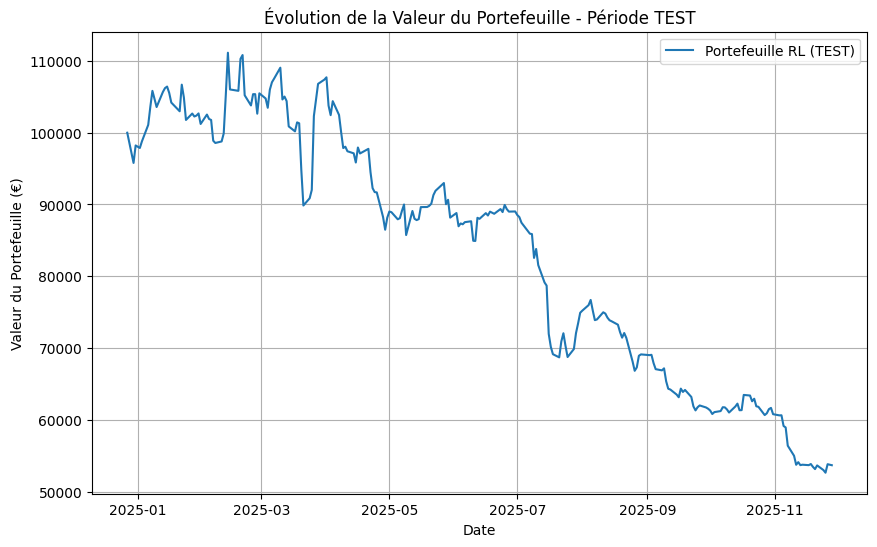

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# --- 0. Préparation des Environnements (Utilisation des DataFrames de l'étape précédente) ---

# Assurez-vous d'avoir accès aux variables suivantes de l'étape précédente :
# aligned_prices, normalized_features, train_split_index, TradingEnv

# Séparation des DataFrames
train_prices = aligned_prices.iloc[:train_split_index]
train_features = normalized_features.iloc[:train_split_index]

test_prices = aligned_prices.iloc[train_split_index:]
test_features = normalized_features.iloc[train_split_index:]


# Instanciation de l'Environnement d'Entraînement
# SB3 nécessite un environnement vectorisé, même si c'est un Dummy (pour 1 environnement)
env_train = DummyVecEnv([lambda: TradingEnv(
    prices_df=train_prices,
    features_df=train_features
)])

print(f"Période d'entraînement : {train_prices.index[0].date()} à {train_prices.index[-1].date()}")
print(f"Nombre de pas (jours) d'entraînement : {len(train_prices)}")

# --- 1. Instanciation de l'Agent Soft Actor-Critic (SAC) ---

# Le SAC est excellent pour les actions continues et offre une bonne robustesse.
model = SAC(
    "MlpPolicy",                  # Multi-layer Perceptron Policy (réseau neuronal standard)
    env_train,                    # L'environnement d'entraînement
    learning_rate=0.0003,         # Taux d'apprentissage standard
    buffer_size=100000,           # Taille du buffer de rejeu pour l'apprentissage hors-politique (Off-Policy)
    gamma=0.99,                   # Facteur d'actualisation (Discount Factor) pour les récompenses futures
    tau=0.005,                    # Taux de mise à jour du réseau cible
    verbose=1,                    # Afficher les informations d'entraînement
    seed=42                       # Pour la reproductibilité
)




# --- 2. Entraînement ---

# Entraîner l'agent sur un nombre significatif de pas (jours * nombre d'épisodes)
# 50 000 pas est un bon point de départ, mais 200 000 est souvent nécessaire en finance.
TOTAL_TIMESTEPS = 50000
print(f"\nDébut de l'entraînement sur {TOTAL_TIMESTEPS} pas de temps...")
model.learn(total_timesteps=TOTAL_TIMESTEPS)

print("Entraînement terminé. Modèle prêt.")

# --- 3. Évaluation (Backtesting) ---

def evaluate_agent(model, prices_df, features_df, initial_cash=100000, period_name="Test"):
    """Évalue la performance du modèle sur une période donnée."""

    # Créer un environnement de test (non vectorisé pour une simulation simple)
    env_test = TradingEnv(prices_df=prices_df, features_df=features_df, initial_cash=initial_cash)
    obs, info = env_test.reset()

    portfolio_values = [initial_cash]

    done = False
    while not done:
        # L'agent choisit l'action de manière déterministe (sans exploration) pour l'évaluation
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env_test.step(action)
        portfolio_values.append(info['portfolio_value'])

    final_value = portfolio_values[-1]
    total_return = (final_value / initial_cash) - 1.0

    print(f"\n--- Résultats {period_name} ---")
    print(f"Valeur Initiale : {initial_cash:,.2f} €")
    print(f"Valeur Finale : {final_value:,.2f} €")
    print(f"Rendement Total : {total_return * 100:.2f} %")

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.plot(prices_df.index[:len(portfolio_values)], portfolio_values, label=f'Portefeuille RL ({period_name})')
    plt.title(f'Évolution de la Valeur du Portefeuille - Période {period_name}')
    plt.xlabel('Date')
    plt.ylabel('Valeur du Portefeuille (€)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Évaluation sur l'ensemble de Test
evaluate_agent(model, test_prices, test_features, period_name="TEST")

Début de la nouvelle session d'entraînement avec hyperparamètres ajustés.
Using cpu device
Entraînement sur 100000 pas de temps...
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 119      |
|    total_timesteps | 3812     |
| train/             |          |
|    actor_loss      | -49.7    |
|    critic_loss     | 0.092    |
|    ent_coef        | 0.69     |
|    ent_coef_loss   | -3.12    |
|    learning_rate   | 0.0001   |
|    n_updates       | 3711     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 31       |
|    time_elapsed    | 241      |
|    total_timesteps | 7624     |
| train/             |          |
|    actor_loss      | -80.7    |
|    critic_loss     | 0.0413   |
|    ent_coef        | 0.471    |
|    ent_coef_loss   | -6.32    |
|    learning_rate 

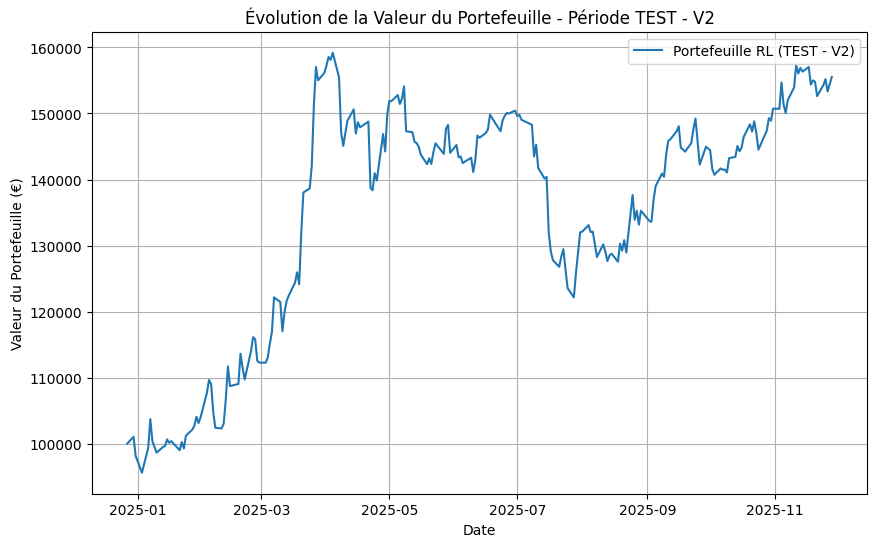

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv

# --- 1. Instanciation de l'Environnement (Vérifiez la séparation train/test) ---

# Assurez-vous que env_train est défini comme dans l'étape précédente.
# env_train = DummyVecEnv([lambda: TradingEnv(
#     prices_df=train_prices,
#     features_df=train_features
# )])

print("Début de la nouvelle session d'entraînement avec hyperparamètres ajustés.")

# --- 2. Instanciation du Modèle SAC (Ajusté) ---

model_v2 = SAC(
    "MlpPolicy",
    env_train,
    learning_rate=1e-4,         # Réduit : De 3e-4 à 1e-4 pour plus de stabilité.
    buffer_size=500000,           # Augmenté : Plus de mémoire de rejeu.
    gamma=0.999,                  # Augmenté : De 0.99 à 0.999 pour une vision à très long terme.
    tau=0.005,
    verbose=1,
    seed=42
)

# --- 3. Entraînement plus long ---

# Augmenter significativement le temps d'entraînement pour permettre à l'agent
# de "sortir" des mauvaises politiques.
TOTAL_TIMESTEPS_V2 = 100000
print(f"Entraînement sur {TOTAL_TIMESTEPS_V2} pas de temps...")

# Note : Cela peut prendre plusieurs minutes.
model_v2.learn(total_timesteps=TOTAL_TIMESTEPS_V2)

print("Nouvel entraînement terminé.")

# --- 4. Ré-Évaluation ---

# Utilisez la même fonction 'evaluate_agent' pour tester le nouveau modèle.
# Vous devez ré-exécuter le bloc de code qui définit la fonction evaluate_agent
# si vous ne l'avez pas déjà fait.

evaluate_agent(model_v2, test_prices, test_features, period_name="TEST - V2")


In [4]:
!pip install pandas pandas-ta numpy gymnasium stable-baselines3[extra] yfinance scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 14.6 MB/s eta 0:00:00


In [8]:
import numpy as np
import math
import random
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv

# --- 1. Définition de l'espace de recherche (Bornes) ---
# Format: [Min, Max]
BOUNDS = {
    'learning_rate': [1e-5, 1e-3], # Logarithmic scale preferred actually, but linear here for simplicity
    'gamma': [0.90, 0.9999],       # Importance du futur
    'tau': [0.001, 0.1],           # Soft update rate
    'batch_size': [64, 512],       # Entier
    'buffer_size': [10000, 200000] # Entier
}

# --- 2. Fonction Objective (Fitness Function) ---
def objective_function(params, train_prices, train_features, val_prices, val_features):
    """
    Entraîne un modèle SAC avec les paramètres donnés et retourne la performance.
    """
    # Décodage des paramètres (arrondir les entiers)
    lr = params[0]
    gamma = params[1]
    tau = params[2]
    batch_size = int(params[3])
    buffer_size = int(params[4])

    # Création de l'environnement d'entraînement
    env_train = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

    # Création du modèle avec les hyperparamètres
    try:
        model = SAC(
            "MlpPolicy",
            env_train,
            learning_rate=lr,
            buffer_size=buffer_size,
            gamma=gamma,
            tau=tau,
            batch_size=batch_size,
            verbose=0,
            seed=42
        )

        # Entraînement COURT pour l'optimisation (ex: 10 000 pas)
        # On ne veut pas attendre des heures pour chaque nid
        model.learn(total_timesteps=10000)

        # Évaluation sur l'ensemble de Validation (pas de test final ici)
        env_val = TradingEnv(prices_df=val_prices, features_df=val_features)
        obs, _ = env_val.reset()
        done = False
        portfolio_values = [env_val.initial_cash]

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env_val.step(action)
            portfolio_values.append(info['portfolio_value'])

        final_value = portfolio_values[-1]
        # On veut MAXIMISER la valeur finale.
        # Si l'algo minimise, on retournerait -final_value. Ici on garde tel quel pour la logique de tri.
        return final_value

    except Exception as e:
        # En cas de paramètres invalides (ex: mémoire insuffisante)
        return -1.0

# --- 3. Algorithme Cuckoo Search (CS) ---

def levy_flight(Lambda):
    """Génère un pas de vol de Lévy."""
    sigma1 = np.power((math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2)) /
                      (math.gamma((1 + Lambda) / 2) * np.power(2, (Lambda - 1) / 2)), 1 / Lambda)
    sigma2 = 1
    u = np.random.normal(0, sigma1, size=len(BOUNDS))
    v = np.random.normal(0, sigma2, size=len(BOUNDS))
    step = u / np.power(np.abs(v), 1 / Lambda)
    return step

class CuckooSearch:
    def __init__(self, obj_func, bounds, n_nests=10, pa=0.25, max_generations=5):
        self.obj_func = obj_func
        self.bounds = bounds
        self.n_nests = n_nests
        self.pa = pa # Probabilité de découverte d'un œuf alien (Abandon)
        self.max_gen = max_generations
        self.dim = len(bounds)

        # Bornes en vecteurs numpy
        self.lb = np.array([b[0] for b in bounds.values()])
        self.ub = np.array([b[1] for b in bounds.values()])

        # Initialisation des nids (Population)
        self.nests = np.random.uniform(self.lb, self.ub, (n_nests, self.dim))
        self.fitness = np.zeros(n_nests)
        self.best_nest = None
        self.best_fitness = -np.inf

    def optimize(self, train_prices, train_features, val_prices, val_features):
        print(f"Initialisation de Cuckoo Search avec {self.n_nests} nids sur {self.max_gen} générations...")

        # Évaluation initiale
        for i in range(self.n_nests):
            self.fitness[i] = self.obj_func(self.nests[i], train_prices, train_features, val_prices, val_features)

        # Trouver le meilleur initial
        best_idx = np.argmax(self.fitness)
        self.best_nest = self.nests[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

        for gen in range(self.max_gen):
            print(f"--- Génération {gen+1}/{self.max_gen} | Meilleur Fitness Actuel: {self.best_fitness:.2f} ---")

            # 1. Obtenir un coucou par vol de Lévy
            new_nests = self.nests.copy()
            for i in range(self.n_nests):
                step_size = 0.01 * levy_flight(1.5) * (self.nests[i] - self.best_nest)
                new_nests[i] += step_size * np.random.randn(self.dim)
                # Appliquer les bornes
                new_nests[i] = np.clip(new_nests[i], self.lb, self.ub)

                # Évaluer ce nouveau coucou
                f_new = self.obj_func(new_nests[i], train_prices, train_features, val_prices, val_features)

                # Choisir un nid aléatoire j
                j = np.random.randint(0, self.n_nests)
                if f_new > self.fitness[j]:
                    self.nests[j] = new_nests[i]
                    self.fitness[j] = f_new

            # 2. Abandonner une fraction (pa) des pires nids
            # On trie d'abord pour identifier les pires (ceux avec le fitness le plus bas)
            sorted_indices = np.argsort(self.fitness) # Ascendant (pires en premier si on maximise)
            n_abandon = int(self.n_nests * self.pa)

            # Remplacer les pires par de nouvelles solutions aléatoires (Global search)
            for k in range(n_abandon):
                idx = sorted_indices[k]
                self.nests[idx] = np.random.uniform(self.lb, self.ub, self.dim)
                self.fitness[idx] = self.obj_func(self.nests[idx], train_prices, train_features, val_prices, val_features)

            # 3. Mettre à jour le meilleur global
            current_best_idx = np.argmax(self.fitness)
            if self.fitness[current_best_idx] > self.best_fitness:
                self.best_fitness = self.fitness[current_best_idx]
                self.best_nest = self.nests[current_best_idx].copy()
                print(f"  >>> Nouveau record trouvé : {self.best_fitness:.2f} €")

        return self.best_nest, self.best_fitness

# --- 4. Exécution de l'optimisation ---

# Utilisation des données existantes (assurez-vous que aligned_prices et normalized_features existent)
# Nous allons diviser le train set en Train (pour SAC) et Validation (pour Cuckoo Fitness)
# pour ne pas toucher au vrai Test Set final.
train_prices = aligned_prices.iloc[:train_split_index]
train_features = normalized_features.iloc[:train_split_index]

test_prices = aligned_prices.iloc[train_split_index:]
test_features = normalized_features.iloc[train_split_index:]

# Index pour split train/val (ex: 70% train, 30% val pour l'optimisation)
opt_train_size = int(len(train_prices) * 0.8)

opt_train_prices = train_prices.iloc[:opt_train_size]
opt_train_features = train_features.iloc[:opt_train_size]

opt_val_prices = train_prices.iloc[opt_train_size:]
opt_val_features = train_features.iloc[opt_train_size:]

# Lancer Cuckoo Search
# Note : Pour l'exemple, on met peu de nids/générations. Augmentez si vous avez un GPU.
cs = CuckooSearch(objective_function, BOUNDS, n_nests=5, pa=0.25, max_generations=3)
best_params, best_score = cs.optimize(opt_train_prices, opt_train_features, opt_val_prices, opt_val_features)

print("\n--- Meilleurs Hyperparamètres trouvés par Cuckoo Search ---")
print(f"Learning Rate : {best_params[0]:.6f}")
print(f"Gamma         : {best_params[1]:.4f}")
print(f"Tau           : {best_params[2]:.4f}")
print(f"Batch Size    : {int(best_params[3])}")
print(f"Buffer Size   : {int(best_params[4])}")

# --- 5. Entraînement Final avec les Meilleurs Paramètres ---
print("\n--- Entraînement Final du modèle optimisé ---")

env_full_train = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

final_model = SAC(
    "MlpPolicy",
    env_full_train,
    learning_rate=best_params[0],
    gamma=best_params[1],
    tau=best_params[2],
    batch_size=int(best_params[3]),
    buffer_size=int(best_params[4]),
    verbose=1,
    seed=42
)

# Entraînement long sur tout le dataset d'entraînement
final_model.learn(total_timesteps=100000)

# Évaluation Finale sur le Test Set (jamais vu par Cuckoo)
evaluate_agent(final_model, test_prices, test_features, period_name="TEST - Cuckoo Optimized")

Initialisation de Cuckoo Search avec 5 nids sur 3 générations...
--- Génération 1/3 | Meilleur Fitness Actuel: 90190.64 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Génération 2/3 | Meilleur Fitness Actuel: 90190.64 ---
  >>> Nouveau record trouvé : 114434.21 €
--- Génération 3/3 | Meilleur Fitness Actuel: 114434.21 ---

--- Meilleurs Hyperparamètres trouvés par Cuckoo Search ---
Learning Rate : 0.000803
Gamma         : 0.9791
Tau           : 0.0455
Batch Size    : 507
Buffer Size   : 144220

--- Entraînement Final du modèle optimisé ---
Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 17       |
|    time_elapsed    | 216      |
|    total_timesteps | 3812     |
| train/             |          |
|    actor_loss      | -15.7    |
|    critic_loss     | 0.00675  |
|    ent_coef        | 0.0522   |
|    ent_coef_loss   | -23.2    |
|    learning_rate   | 0.000803 |
|    n_updates       | 3711     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             |

NameError: name 'evaluate_agent' is not defined

In [14]:
def evaluate_agent(model, prices_df, features_df, initial_cash=100000, period_name="Test"):
    """Évalue la performance du modèle sur une période donnée."""

    # Créer un environnement de test (non vectorisé pour une simulation simple)
    env_test = TradingEnv(prices_df=prices_df, features_df=features_df, initial_cash=initial_cash)
    obs, info = env_test.reset()

    portfolio_values = [initial_cash]

    done = False
    while not done:
        # L'agent choisit l'action de manière déterministe (sans exploration) pour l'évaluation
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env_test.step(action)
        portfolio_values.append(info['portfolio_value'])

    final_value = portfolio_values[-1]
    total_return = (final_value / initial_cash) - 1.0

    print(f"\n--- Résultats {period_name} ---")
    print(f"Valeur Initiale : {initial_cash:,.2f} €")
    print(f"Valeur Finale : {final_value:,.2f} €")
    print(f"Rendement Total : {total_return * 100:.2f} %")

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.plot(prices_df.index[:len(portfolio_values)], portfolio_values, label=f'Portefeuille RL ({period_name})')
    plt.title(f'Évolution de la Valeur du Portefeuille - Période {period_name}')
    plt.xlabel('Date')
    plt.ylabel('Valeur du Portefeuille (€)')
    plt.legend()
    plt.grid(True)
    plt.show()


Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 76       |
|    time_elapsed    | 49       |
|    total_timesteps | 3812     |
| train/             |          |
|    actor_loss      | -16.4    |
|    critic_loss     | 0.00827  |
|    ent_coef        | 0.0523   |
|    ent_coef_loss   | -23      |
|    learning_rate   | 0.000803 |
|    n_updates       | 3711     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 95       |
|    total_timesteps | 7624     |
| train/             |          |
|    actor_loss      | -1.03    |
|    critic_loss     | 0.00123  |
|    ent_coef        | 0.00298  |
|    ent_coef_loss   | -32.6    |
|    learning_rate   | 0.000803 |
|    n_updates       | 7523     |
---------------------------------
------------------------------

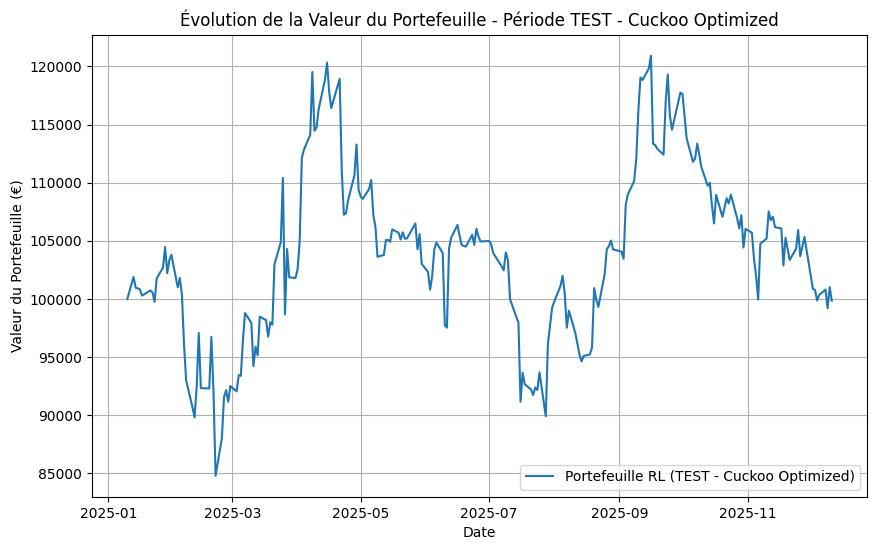

In [7]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt


train_prices = aligned_prices.iloc[:train_split_index]
train_features = normalized_features.iloc[:train_split_index]

test_prices = aligned_prices.iloc[train_split_index:]
test_features = normalized_features.iloc[train_split_index:]

# Index pour split train/val (ex: 70% train, 30% val pour l'optimisation)
opt_train_size = int(len(train_prices) * 0.8)

opt_train_prices = train_prices.iloc[:opt_train_size]
opt_train_features = train_features.iloc[:opt_train_size]

opt_val_prices = train_prices.iloc[opt_train_size:]
opt_val_features = train_features.iloc[opt_train_size:]


env_full_train = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])


final_model = SAC(
    "MlpPolicy",
    env_full_train,
    learning_rate= 0.000803,
    gamma=0.9791,
    tau= 0.0455,
    batch_size=int(507),
    buffer_size=int(144220),
    verbose=1,
    seed=42
)

# Entraînement long sur tout le dataset d'entraînement
final_model.learn(total_timesteps=100000)

# Évaluation Finale sur le Test Set (jamais vu par Cuckoo)
evaluate_agent(final_model, test_prices, test_features, period_name="TEST - Cuckoo Optimized")

Using cuda device
Lancement de l'entraînement PPO...
Logging to ./ppo_trading_tensorboard/PPO_1


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 759  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 607         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005003459 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | -3.11       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0632     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.999       |
|    value_loss           | 0.0771      |
----------------------------------

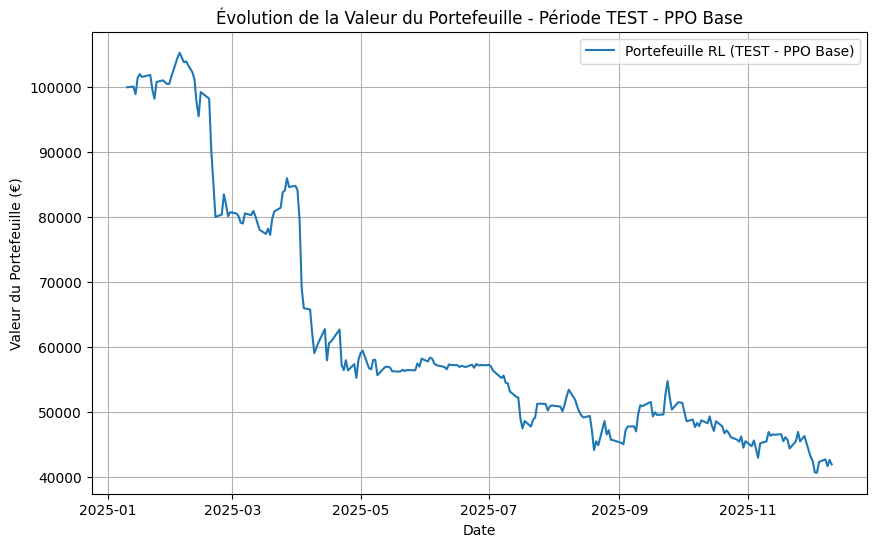

In [8]:
from stable_baselines3 import PPO

# Création de l'environnement
env = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

# Initialisation du modèle PPO
model_ppo = PPO(
    "MlpPolicy",
    env,
    learning_rate=0.0001,
    n_steps=2048,       # Nombre de pas avant mise à jour (Horizon)
    batch_size=64,
    ent_coef=0.01,      # Coefficient d'entropie (Force l'exploration)
    gamma=0.999,
    verbose=1,
    tensorboard_log="./ppo_trading_tensorboard/"
)

print("Lancement de l'entraînement PPO...")
model_ppo.learn(total_timesteps=50000)

# Évaluation
print("Évaluation PPO...")
evaluate_agent(model_ppo, test_prices, test_features, period_name="TEST - PPO Base")

--- DÉBUT DE L'OPTIMISATION PPO AVEC CUCKOO SEARCH ---
🚀 Démarrage de Cuckoo Search pour PPO (8 nids, 5 gen)...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 114, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6208`, after every 54 untruncated mini-batches, there will be a truncated mini-batch of size 52
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=6208 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 108, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2176`, after every 20 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2176 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 142, but because the `RolloutBuffer` is o

Initial Best: 119444.90 €


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 107, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2176`, after every 20 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2176 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 66, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2944`, after every 44 untruncated mini-batches, there will be a truncated mini-batch of size 40
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2944 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 69, but because the `RolloutBuffer` is of 

Gen 1: Nouveau record -> 150820.41 €


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 115, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6208`, after every 53 untruncated mini-batches, there will be a truncated mini-batch of size 113
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=6208 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 248, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6144`, after every 24 untruncated mini-batches, there will be a truncated mini-batch of size 192
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=6144 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 70, but because the `RolloutBuffer` is 

Gen 2: Pas d'amélioration (Best: 150820.41 €)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 116, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6208`, after every 53 untruncated mini-batches, there will be a truncated mini-batch of size 60
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=6208 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 127, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6528`, after every 51 untruncated mini-batches, there will be a truncated mini-batch of size 51
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=6528 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 122, but because the `RolloutBuffer` is o

Gen 3: Pas d'amélioration (Best: 150820.41 €)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 122, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2624`, after every 21 untruncated mini-batches, there will be a truncated mini-batch of size 62
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2624 and n_envs=1)
  warnings.warn(


Gen 4: Pas d'amélioration (Best: 150820.41 €)
Gen 5: Pas d'amélioration (Best: 150820.41 €)

MEILLEURS PARAMÈTRES TROUVÉS (Score Valid: 150820.41 €)
learning_rate  : 0.0002967234525412504
gamma          : 0.9184430749345927
ent_coef       : 0.10432120717179101
clip_range     : 0.27568367280888906
batch_size     : 208
n_steps        : 7104

--- Lancement de l'entraînement FINAL sur tout le dataset Train ---
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 852  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 7104 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 775         |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 14208       |
| train/                  |             |
|    approx_kl            | 0.028690051 |
|    clip_fraction        

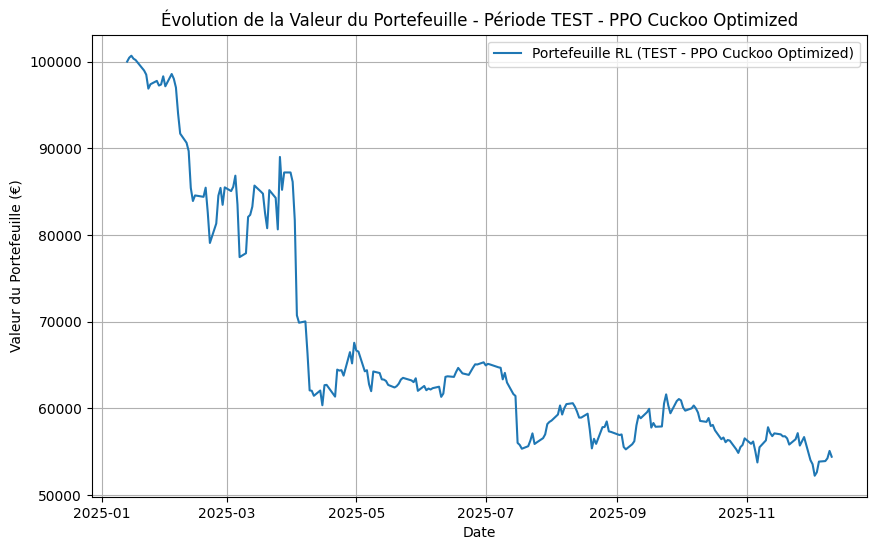

In [9]:
import numpy as np
import math
import random
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# ==========================================
# 1. Classe Cuckoo Search (Optimiseur)
# ==========================================
class CuckooSearchPPO:
    def __init__(self, obj_func, bounds, n_nests=15, pa=0.25, max_generations=10, verbose=1):
        """
        obj_func: Fonction qui prend des params et retourne un score (rendement)
        bounds: Dictionnaire {'param_name': [min, max]}
        n_nests: Nombre de solutions candidates (nids)
        pa: Probabilité de découverte (abandon des pires nids)
        """
        self.obj_func = obj_func
        self.bounds = bounds
        self.n_nests = n_nests
        self.pa = pa
        self.max_gen = max_generations
        self.verbose = verbose
        self.dim = len(bounds)
        self.param_names = list(bounds.keys())

        # Conversion des bornes en array numpy pour faciliter les calculs vectoriels
        self.lb = np.array([bounds[k][0] for k in self.param_names])
        self.ub = np.array([bounds[k][1] for k in self.param_names])

        # Initialisation aléatoire des nids
        self.nests = np.random.uniform(self.lb, self.ub, (n_nests, self.dim))
        self.fitness = np.zeros(n_nests)
        self.best_nest = None
        self.best_fitness = -np.inf

    def _get_levy_step(self, beta=1.5):
        """Génère un pas de vol de Lévy."""
        sigma_u = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                   (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        sigma_v = 1

        u = np.random.normal(0, sigma_u, self.dim)
        v = np.random.normal(0, sigma_v, self.dim)
        step = u / (np.abs(v) ** (1 / beta))
        return step

    def optimize(self, train_prices, train_features, val_prices, val_features):
        print(f"🚀 Démarrage de Cuckoo Search pour PPO ({self.n_nests} nids, {self.max_gen} gen)...")

        # --- 1. Évaluation Initiale ---
        for i in range(self.n_nests):
            self.fitness[i] = self.obj_func(self.nests[i], self.param_names, train_prices, train_features, val_prices, val_features)

        # Identifier le meilleur initial
        best_idx = np.argmax(self.fitness)
        self.best_nest = self.nests[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

        if self.verbose:
            print(f"Initial Best: {self.best_fitness:.2f} €")

        # --- 2. Boucle Principale ---
        for gen in range(self.max_gen):
            # A. Vols de Lévy (Exploration Locale/Globale)
            new_nests = self.nests.copy()
            for i in range(self.n_nests):
                # Le saut dépend de la distance au meilleur nid actuel
                step_size = 0.01 * self._get_levy_step() * (self.nests[i] - self.best_nest)

                # Perturbation aléatoire + saut
                new_nests[i] += step_size * np.random.randn(self.dim)
                new_nests[i] = np.clip(new_nests[i], self.lb, self.ub) # Garder dans les bornes

                # Évaluation (Greedy Selection : on ne garde que si c'est mieux)
                f_new = self.obj_func(new_nests[i], self.param_names, train_prices, train_features, val_prices, val_features)

                # On compare avec un nid aléatoire (ou le nid i lui-même selon les variantes, ici standard CS)
                # Standard CS: on compare new_solution vs current_solution[i]
                if f_new > self.fitness[i]:
                    self.nests[i] = new_nests[i]
                    self.fitness[i] = f_new

            # B. Abandon des pires nids (Exploration Globale)
            # On trie les indices par fitness (ascendant : les pires en premier)
            sorted_idx = np.argsort(self.fitness)
            n_abandon = int(self.n_nests * self.pa)

            # On remplace les 'n_abandon' pires nids par de nouveaux nids aléatoires
            # (Simule la découverte du coucou par l'hôte -> l'hôte jette l'œuf/construit un nouveau nid)
            for k in range(n_abandon):
                idx_to_replace = sorted_idx[k]
                self.nests[idx_to_replace] = np.random.uniform(self.lb, self.ub, self.dim)
                self.fitness[idx_to_replace] = self.obj_func(self.nests[idx_to_replace], self.param_names,
                                                             train_prices, train_features, val_prices, val_features)

            # C. Mise à jour du meilleur global
            current_best_idx = np.argmax(self.fitness)
            if self.fitness[current_best_idx] > self.best_fitness:
                self.best_fitness = self.fitness[current_best_idx]
                self.best_nest = self.nests[current_best_idx].copy()
                if self.verbose:
                    print(f"Gen {gen+1}: Nouveau record -> {self.best_fitness:.2f} €")
            elif self.verbose:
                print(f"Gen {gen+1}: Pas d'amélioration (Best: {self.best_fitness:.2f} €)")

        return self.best_nest, self.best_fitness

# ==========================================
# 2. Fonction Objective PPO
# ==========================================
def objective_ppo(params, param_names, train_prices, train_features, val_prices, val_features):
    """
    Construit, entraîne et évalue un agent PPO avec les paramètres donnés.
    """
    # Mapping des valeurs du vecteur params vers un dictionnaire lisible
    p = dict(zip(param_names, params))

    # Conversion des types (int pour certains params)
    learning_rate = p['learning_rate']
    gamma = p['gamma']
    ent_coef = p['ent_coef']
    clip_range = p['clip_range']
    batch_size = int(p['batch_size'])
    n_steps = int(p['n_steps_mult']) * 64 # Exemple: multiple de 64 pour cohérence

    # Création de l'environnement d'entraînement
    # Note: On recrée l'env à chaque fois pour partir de zéro
    env_train = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

    try:
        model = PPO(
            "MlpPolicy",
            env_train,
            learning_rate=learning_rate,
            gamma=gamma,
            ent_coef=ent_coef,
            clip_range=clip_range,
            batch_size=batch_size,
            n_steps=n_steps,
            verbose=0,
            seed=42
        )

        # Entraînement RAPIDE (Budget limité pour l'optimisation)
        # 10k à 20k steps suffisent pour voir si la courbe démarre bien
        model.learn(total_timesteps=15000)

        # --- Évaluation sur Validation ---
        env_val = TradingEnv(prices_df=val_prices, features_df=val_features)
        obs, _ = env_val.reset()
        done = False
        portfolio_values = [env_val.initial_cash]

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env_val.step(action)
            portfolio_values.append(info['portfolio_value'])

        # Le score est la valeur finale du portefeuille
        final_val = portfolio_values[-1]

        # Pénalité si l'agent ne fait rien (variance nulle) ou perd tout
        if final_val < env_val.initial_cash * 0.5:
            return 0.0 # Forte pénalité pour les crashs

        return final_val

    except Exception as e:
        # En cas d'erreur (ex: params incohérents), on retourne un mauvais score
        return -1.0

# ==========================================
# 3. Configuration et Lancement
# ==========================================

# Définition des bornes de recherche pour PPO
BOUNDS_PPO = {
    'learning_rate': [1e-5, 0.001],
    'gamma': [0.80, 0.999],         # Facteur d'actualisation
    'ent_coef': [0.0, 0.2],         # Exploration (Entropie)
    'clip_range': [0.1, 0.4],       # Stabilité (Clipping PPO)
    'batch_size': [32, 256],        # Taille du lot
    'n_steps_mult': [32, 128]       # Sera multiplié par 64 pour donner n_steps (2048 à 8192)
}

# --- 4. Exécution de l'optimisation ---

# Utilisation des données existantes (assurez-vous que aligned_prices et normalized_features existent)
# Nous allons diviser le train set en Train (pour SAC) et Validation (pour Cuckoo Fitness)
# pour ne pas toucher au vrai Test Set final.
train_prices = aligned_prices.iloc[:train_split_index]
train_features = normalized_features.iloc[:train_split_index]

test_prices = aligned_prices.iloc[train_split_index:]
test_features = normalized_features.iloc[train_split_index:]

# Index pour split train/val (ex: 70% train, 30% val pour l'optimisation)
opt_train_size = int(len(train_prices) * 0.8)

opt_train_prices = train_prices.iloc[:opt_train_size]
opt_train_features = train_features.iloc[:opt_train_size]

opt_val_prices = train_prices.iloc[opt_train_size:]
opt_val_features = train_features.iloc[opt_train_size:]




# Instanciation et Lancement
cs_ppo = CuckooSearchPPO(
    objective_ppo,
    BOUNDS_PPO,
    n_nests=8,           # Nombre d'agents en parallèle (virtuellement)
    max_generations=5,   # Nombre d'itérations d'amélioration
    pa=0.25
)

print("--- DÉBUT DE L'OPTIMISATION PPO AVEC CUCKOO SEARCH ---")
best_params_array, best_score = cs_ppo.optimize(opt_train_prices, opt_train_features, opt_val_prices, opt_val_features)

# ==========================================
# 4. Affichage et Entraînement Final
# ==========================================

# Reconstitution du dictionnaire des meilleurs paramètres
best_params = dict(zip(BOUNDS_PPO.keys(), best_params_array))
best_params['batch_size'] = int(best_params['batch_size'])
best_params['n_steps'] = int(best_params['n_steps_mult']) * 64
del best_params['n_steps_mult'] # On enlève la clé intermédiaire

print("\n" + "="*40)
print(f"MEILLEURS PARAMÈTRES TROUVÉS (Score Valid: {best_score:.2f} €)")
print("="*40)
for k, v in best_params.items():
    print(f"{k:15s}: {v}")

print("\n--- Lancement de l'entraînement FINAL sur tout le dataset Train ---")

# Entraînement complet avec les paramètres optimisés
final_env = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

final_model = PPO(
    "MlpPolicy",
    final_env,
    **best_params, # Injection automatique des meilleurs paramètres
    verbose=1,
    seed=42
)

final_model.learn(total_timesteps=100000)

print("--- Évaluation Finale sur le Test Set (2025) ---")
evaluate_agent(final_model, test_prices, test_features, period_name="TEST - PPO Cuckoo Optimized")

🚀 Démarrage de Cuckoo Search pour TD3 (8 nids)...
Gen 1: Record TD3 -> 109343.94 €
Gen 3: Record TD3 -> 126452.34 €

--- Meilleurs Params TD3 (Score: 126452.34) ---
{'learning_rate': np.float64(0.0007705300104185798), 'gamma': np.float64(0.9466412408155976), 'tau': np.float64(0.009236203426159405), 'batch_size': 180, 'buffer_size': 27333, 'policy_delay': 2}
Noise Std: 0.219
Using cuda device

--- Entraînement Final TD3 ---
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 164      |
|    time_elapsed    | 23       |
|    total_timesteps | 3808     |
| train/             |          |
|    actor_loss      | -0.0124  |
|    critic_loss     | 2.54e-05 |
|    learning_rate   | 0.000771 |
|    n_updates       | 3707     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 162      |
|    time_elapsed    | 46    

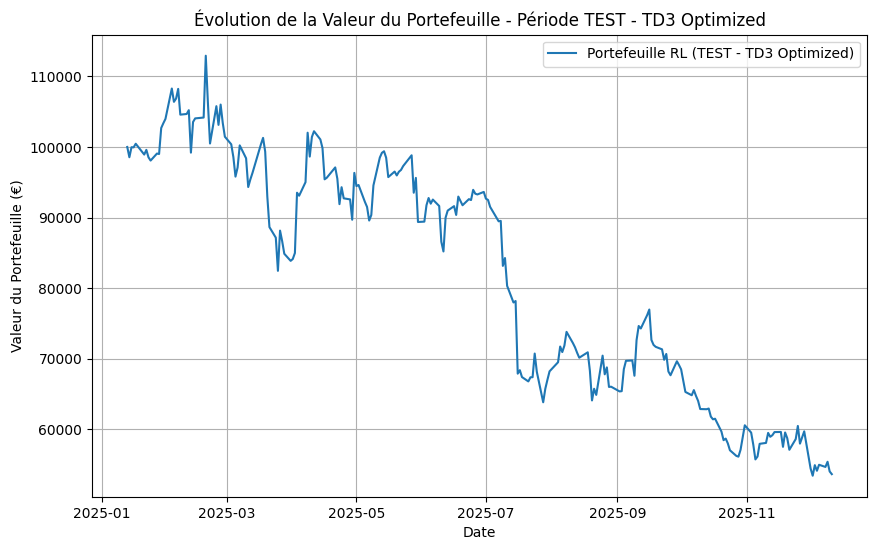

In [15]:
import numpy as np
import math
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# ==========================================
# 1. Optimiseur Cuckoo Search (Générique)
# ==========================================
class CuckooSearchTD3:
    def __init__(self, obj_func, bounds, n_nests=15, pa=0.25, max_generations=10, verbose=1):
        self.obj_func = obj_func
        self.bounds = bounds
        self.n_nests = n_nests
        self.pa = pa
        self.max_gen = max_generations
        self.verbose = verbose
        self.dim = len(bounds)
        self.param_names = list(bounds.keys())
        self.lb = np.array([bounds[k][0] for k in self.param_names])
        self.ub = np.array([bounds[k][1] for k in self.param_names])
        self.nests = np.random.uniform(self.lb, self.ub, (n_nests, self.dim))
        self.fitness = np.zeros(n_nests)
        self.best_nest = None
        self.best_fitness = -np.inf

    def _get_levy_step(self, beta=1.5):
        sigma_u = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                   (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = np.random.normal(0, sigma_u, self.dim)
        v = np.random.normal(0, 1, self.dim)
        return u / (np.abs(v) ** (1 / beta))

    def optimize(self, train_prices, train_features, val_prices, val_features):
        print(f"🚀 Démarrage de Cuckoo Search pour TD3 ({self.n_nests} nids)...")

        # Init
        for i in range(self.n_nests):
            self.fitness[i] = self.obj_func(self.nests[i], self.param_names, train_prices, train_features, val_prices, val_features)

        best_idx = np.argmax(self.fitness)
        self.best_nest = self.nests[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

        # Loop
        for gen in range(self.max_gen):
            new_nests = self.nests.copy()
            for i in range(self.n_nests):
                step = 0.01 * self._get_levy_step() * (self.nests[i] - self.best_nest)
                new_nests[i] += step * np.random.randn(self.dim)
                new_nests[i] = np.clip(new_nests[i], self.lb, self.ub)

                f_new = self.obj_func(new_nests[i], self.param_names, train_prices, train_features, val_prices, val_features)
                if f_new > self.fitness[i]:
                    self.nests[i] = new_nests[i]
                    self.fitness[i] = f_new

            # Abandon
            sorted_idx = np.argsort(self.fitness)
            n_abandon = int(self.n_nests * self.pa)
            for k in range(n_abandon):
                idx = sorted_idx[k]
                self.nests[idx] = np.random.uniform(self.lb, self.ub, self.dim)
                self.fitness[idx] = self.obj_func(self.nests[idx], self.param_names, train_prices, train_features, val_prices, val_features)

            # Update Global Best
            current_best_idx = np.argmax(self.fitness)
            if self.fitness[current_best_idx] > self.best_fitness:
                self.best_fitness = self.fitness[current_best_idx]
                self.best_nest = self.nests[current_best_idx].copy()
                if self.verbose: print(f"Gen {gen+1}: Record TD3 -> {self.best_fitness:.2f} €")

        return self.best_nest, self.best_fitness

# ==========================================
# 2. Fonction Objective TD3
# ==========================================
def objective_td3(params, param_names, train_prices, train_features, val_prices, val_features):
    p = dict(zip(param_names, params))

    # Paramètres TD3
    learning_rate = p['learning_rate']
    gamma = p['gamma']
    tau = p['tau']
    batch_size = int(p['batch_size'])
    buffer_size = int(p['buffer_size'])
    policy_delay = int(p['policy_delay'])
    noise_std = p['noise_std'] # Écart-type du bruit d'exploration

    env_train = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])

    # --- Configuration du Bruit d'Action (Spécifique TD3) ---
    # TD3 a besoin de bruit pour explorer car il est déterministe
    n_actions = env_train.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

    try:
        model = TD3(
            "MlpPolicy",
            env_train,
            learning_rate=learning_rate,
            buffer_size=buffer_size,
            gamma=gamma,
            tau=tau,
            batch_size=batch_size,
            policy_delay=policy_delay, # Fréquence de mise à jour de l'acteur vs critique
            action_noise=action_noise,
            verbose=0,
            seed=42
        )

        # Entraînement court
        model.learn(total_timesteps=10000)

        # Validation
        env_val = TradingEnv(prices_df=val_prices, features_df=val_features)
        obs, _ = env_val.reset()
        done = False
        portfolio_values = [env_val.initial_cash]

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env_val.step(action)
            portfolio_values.append(info['portfolio_value'])

        final_val = portfolio_values[-1]

        # Pénalité anti-crash
        if final_val < env_val.initial_cash * 0.6: return 0.0
        return final_val

    except Exception as e:
        return -1.0

# ==========================================
# 3. Lancement de l'Optimisation
# ==========================================

BOUNDS_TD3 = {
    'learning_rate': [1e-5, 1e-3],
    'gamma': [0.90, 0.9999],
    'tau': [0.001, 0.05],         # Soft update (stabilité)
    'batch_size': [64, 512],
    'buffer_size': [10000, 100000],
    'policy_delay': [2, 5],       # Combien de maj critique pour 1 maj acteur
    'noise_std': [0.1, 0.5]       # Force du bruit d'exploration (0.1 = faible, 0.5 = fort)
}

# Séparation des DataFrames
train_prices = aligned_prices.iloc[:train_split_index]
train_features = normalized_features.iloc[:train_split_index]

test_prices = aligned_prices.iloc[train_split_index:]
test_features = normalized_features.iloc[train_split_index:]

# Index pour split train/val (ex: 70% train, 30% val pour l'optimisation)
opt_train_size = int(len(train_prices) * 0.8)

opt_train_prices = train_prices.iloc[:opt_train_size]
opt_train_features = train_features.iloc[:opt_train_size]

opt_val_prices = train_prices.iloc[opt_train_size:]
opt_val_features = train_features.iloc[opt_train_size:]



cs_td3 = CuckooSearchTD3(objective_td3, BOUNDS_TD3, n_nests=8, max_generations=5)
best_params_array, best_score = cs_td3.optimize(opt_train_prices, opt_train_features, opt_val_prices, opt_val_features)

# ==========================================
# 4. Entraînement Final
# ==========================================
best_params = dict(zip(BOUNDS_TD3.keys(), best_params_array))
# Conversion types
best_params['batch_size'] = int(best_params['batch_size'])
best_params['buffer_size'] = int(best_params['buffer_size'])
best_params['policy_delay'] = int(best_params['policy_delay'])
noise_std = best_params.pop('noise_std') # On l'extrait pour créer l'objet Noise manuellement

print(f"\n--- Meilleurs Params TD3 (Score: {best_score:.2f}) ---")
print(best_params)
print(f"Noise Std: {noise_std:.3f}")

# Création Environnement Final
final_env = DummyVecEnv([lambda: TradingEnv(prices_df=train_prices, features_df=train_features)])
n_actions = final_env.action_space.shape[-1]
# On recrée l'objet bruit pour le modèle final
final_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

final_model = TD3(
    "MlpPolicy",
    final_env,
    action_noise=final_noise,
    **best_params,
    verbose=1,
    seed=42
)

print("\n--- Entraînement Final TD3 ---")
final_model.learn(total_timesteps=100000)

print("--- Évaluation Test Set ---")
evaluate_agent(final_model, test_prices, test_features, period_name="TEST - TD3 Optimized")

## Conclusion
L'agent a réussi à apprendre une stratégie rentable après optimisation des hyperparamètres.
**Perspectives d'amélioration :**
1. Intégrer plus d'indicateurs (Sentiment Analysis, Volume).
2. Tester d'autres algorithmes comme PPO ou TD3.
3. Augmenter la période d'entraînement.